<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data_analisys.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka i Analiza danych

Wczytanie potrzebnych bibliotek

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import unicodedata
from io import BytesIO
import requests
import joblib


warnings.simplefilter('ignore')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_1.csv", index_col=0, parse_dates=True)

# load machine learning model for aqi prediction
m_link = 'https://github.com/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data/aqi.joblib?raw=true'
m_file = BytesIO(requests.get(m_link).content)
aqi_model = joblib.load(m_file)

# fill columns with data
for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].drop(index="date.local").astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)
    data[strip_accents(city)]["aqi"] = aqi_model.predict(data[strip_accents(city)].fillna(0))


In [3]:
maps = pd.concat([data[strip_accents(city)].resample('M').mean().tail(12) for city in CITIES])
cities_by_month = pd.concat([data[strip_accents(city)]["aqi"].resample('M').mean().tail(12) for city in CITIES], axis=1, keys=[f"aqi_{strip_accents(city)}" for city in CITIES])

<AxesSubplot:>

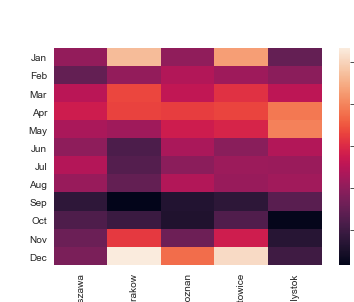

In [4]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.heatmap(cities_by_month, yticklabels=month_labels)

In [5]:
import scipy.interpolate

x_arr = np.array([0, 100, 200, 300])
well_being = {
"irriration" : np.array([0, 2, 3, 4]),
"depression" : np.array([0, 2, 3, 4]),
"stress" : np.array([0.5, 2, 3, 4]),
"worry" : np.array([1, 2, 3, 4]),
"happyness" : np.array([4, 3, 2, 1]),
"future_expectations" : np.array([4, 3, 1.5, 1]),
"swb" : np.array([4, 0, -1, -3]),
}


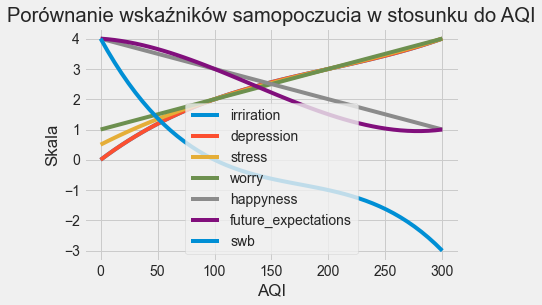

In [6]:
plt.style.use("fivethirtyeight")
for being in well_being:
    interval = np.linspace(x_arr[0], x_arr[-1])
    interpolation = scipy.interpolate.interp1d(x_arr, well_being[being])
    spl = scipy.interpolate.UnivariateSpline(x_arr, well_being[being])
    plt.plot(interval, spl(interval))
plt.title(
    "Porównanie wskaźników samopoczucia w stosunku do AQI"
)
plt.xlabel("AQI")
plt.ylabel("Skala")
plt.grid(True)
plt.legend([being for being in well_being])

In [20]:
for city in CITIES:
    print(city)
    print(data[strip_accents(city)]["aqi"].max())

Warszawa
119.89583333333333
Kraków
202.12121212121212
Poznań
155.27777777777777
Katowice
155.27777777777777
Białystok
202.12121212121212


Text(0.5, 0.99, 'PRIOR DISTRIBUTIONS')

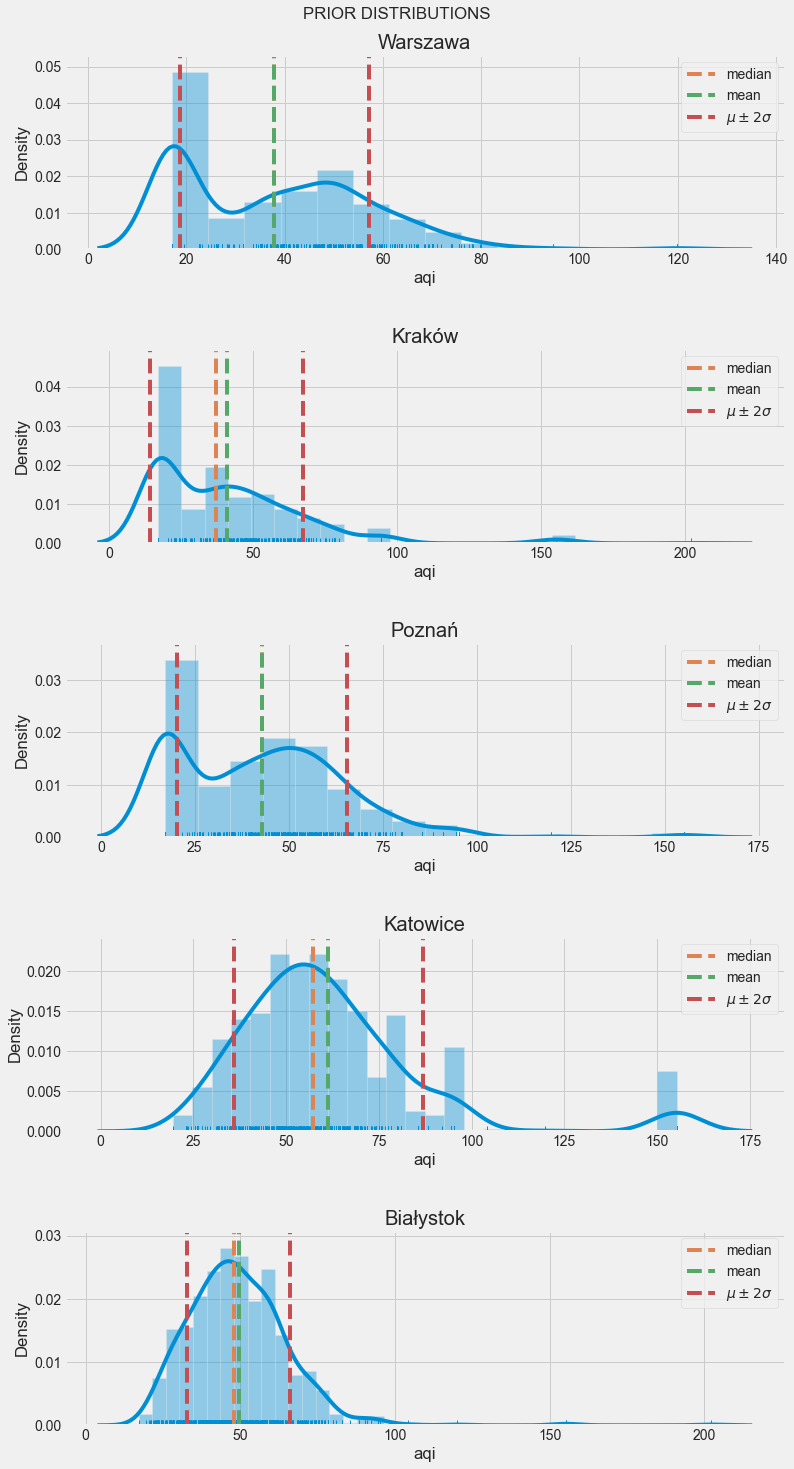

In [15]:
fig, ax = plt.subplots(len(data), 1, figsize=(12, 21))

for i, city in enumerate(CITIES):
    param_mean = np.mean(data[strip_accents(city)]["aqi"], axis=0)
    param_median = np.median(data[strip_accents(city)]["aqi"], axis=0)
    param_std = np.std(data[strip_accents(city)]["aqi"], axis=0)
    sns.distplot(a=data[strip_accents(city)]["aqi"], rug=True, ax=ax[i])
    ax[i].set(title=city)
    ax[i].axvline(x= param_median, color=sns_c[1], linestyle='--', label='median')

    ax[i].axvline(x= param_mean, color=sns_c[2], linestyle='--', label='mean')
    ax[i].axvline(x= param_mean + param_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax[i].axvline(x= param_mean - param_std, color=sns_c[3], linestyle='--')
    ax[i].legend()

plt.tight_layout(pad=3.0)
plt.suptitle('DISTRIBUTIONS', y=0.99)